In [49]:
            import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Bilateral filter

Theory from [this paper](http://people.csail.mit.edu/sparis/publi/2009/fntcgv/Paris_09_Bilateral_filtering.pdf)

## generate image

<matplotlib.colorbar.Colorbar instance at 0x7fe1cba59830>

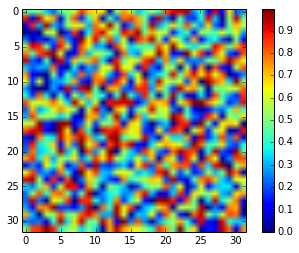

In [50]:
# picture
picture = np.random.random((32, 32))
plt.imshow(picture);
plt.colorbar()

## helper function

In [51]:
def gaussian(x2, sigma):
    """get gaussian coefficient with x^2 as input"""
    return np.exp(-.5*x2/sigma**2)

## input parameters

The bilateral filter takes 2 inputs (and one optional):

 - sigma_r is the standard deviation of the bilateral filter
 - sigma_s is the standard deviation of the gaussian blur
 - truncate is the value at which we truncate. This is an optimization. We assume that the coefficient are negligeable at max(sigma)*truncate since the gaussian shape is exponentially decaying.

In [52]:
sigma_r = 2.
sigma_s = 2.
truncate = 4.
lw = int(max(sigma_r, sigma_s)*truncate)
print lw

8


## preprocess

Here we pad around the input picture. This is necessary because we will take a window around the picture to compute its output value. In the current implementation we use the numpy.pad function and we use the 'reflect mode'.

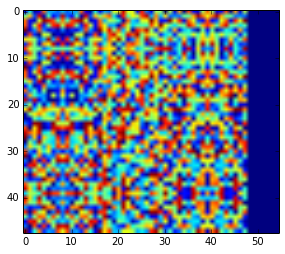

In [53]:
imsize = np.shape(picture)

input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')
plt.imshow(input_im);

## filter algorithm

3 level of parallelism:

1. for each pixel launch a process
2. for each line in the window do a prange
3. within the line use AVX

Nota Bene:

- [i,j] index in input_im
- [i-lw, j-lw]index in output

In [59]:
start = time.time()
output = picture * 0

# to implement with multi process
for i in range(lw, imsize[0] + lw):
    for j in range(lw, imsize[1] + lw):

        # window contining halo
        window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
        assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
        windowsize = np.shape(window)
        
        # initialize normalization term and output term
        sumg = 0
        local_output = 0
        I_pixel = window[lw, lw]
        
        for k in range(windowsize[0]):
            for l in range(0, windowsize[1], 8):
                # take local_input which will become an AVX 8-array
                local_input = window[k,l:l+8]
                assert np.size(local_input) == 8
                
                for cur in range(8):
                    # don't consider the pixel if it is outside the window
                    if l + cur < 2 * lw + 1:
                        coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                        coef *= gaussian((local_input[cur] - I_pixel)**2, sigma_r)
                        local_output += coef * local_input[cur]
                        sumg += coef
        
        output[i-lw, j-lw] = local_output / sumg

<matplotlib.colorbar.Colorbar instance at 0x7fe1cb778d40>

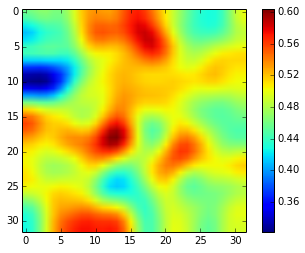

In [60]:
plt.imshow(output);
plt.colorbar()

scipy 0.292752981186


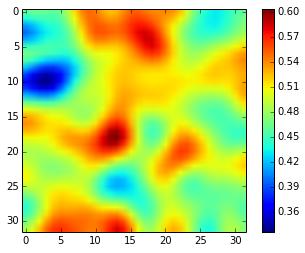

In [61]:
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
start = time.time()
blur = gaussian_filter(picture, 2)
plt.imshow(blur);
plt.colorbar()
print "scipy", time.time() - start